In [6]:
from typing import List, Mapping
from itertools import zip_longest
from glob import iglob
from pickle import load

import numpy as np
from numpy.random import normal, choice, rand
from numpy.polynomial.legendre import Legendre
import matplotlib.pyplot as plt
from h5py import File

from vmitools import (
    abel_inverse, finite_legendre_transform_in_theta,
    interp, tohist, transpose_linearly, transpose_to_drdomega, transpose_to_drdth,
    mrot, mhorshear, msqueeze,
)

In [8]:
run = 298
filename = next(iglob(f"/data/*/Run_{run:03d}/work/reduced.pickle"))
print(f"Reading file {filename}")

with open(filename, 'br') as f:
    df = load(f)
df

sum   count
is_bg delay atmax                                                           
False -6.78 530    [[209.0, 206.0, 212.0, 217.0, 213.0, 207.0, 22...     2.0
            535    [[430.0, 415.0, 421.0, 427.0, 423.0, 422.0, 45...     4.0
            540    [[14340.0, 14349.0, 14242.0, 14419.0, 14512.0,...   136.0
            545    [[258113.0, 255195.0, 256315.0, 259432.0, 2607...  2458.0
            550    [[623352.0, 616677.0, 618635.0, 626153.0, 6288...  5947.0
            555    [[761781.0, 753923.0, 756059.0, 764562.0, 7686...  7267.0
            560    [[380986.0, 377408.0, 378132.0, 382578.0, 3844...  3628.0
            565    [[30986.0, 30657.0, 30733.0, 31120.0, 31341.0,...   294.0
            570    [[2411.0, 2403.0, 2404.0, 2412.0, 2423.0, 2391...    23.0
            575    [[3774.0, 3717.0, 3763.0, 3793.0, 3780.0, 3747...    36.0
            580    [[3674.0, 3602.0, 3638.0, 3687.0, 3698.0, 3596...    35.0
True  -6.78 530    [[108.0, 106.0, 108.0, 106.0, 105.0, 100.0, 11...     1.0
            540    [[6417.0, 6404.0, 6445.0, 6482.0, 6511.0, 6433...    62.0
            545    [[131295.0, 129742.0, 130329.0, 131471.0, 1323...  1259.0
            550    [[317208.0, 313814.0, 315207.0, 318818.0, 3199...  3043.0
            555    [[375858.0, 370506.0, 373094.0, 376902.0, 3786...  3601.0
            560    [[186410.0, 183885.0, 185288.0, 186842.0, 1880...  1790.0
            565    [[13330.0, 13132.0, 13186.0, 13422.0, 13375.0,...   128.0
            570    [[1030.0, 1048.0, 1016.0, 1039.0, 1047.0, 1040...    10.0
            575    [[1559.0, 1532.0, 1544.0, 1555.0, 1567.0, 1541...    15.0
            580    [[2156.0, 2126.0, 2161.0, 2155.0, 2196.0, 2166...    21.0

In [11]:
avg = df['sum'] / df['count']
diff = avg.loc[False] - avg.loc[True]
diff

delay  atmax
-6.78  530      [[-3.5, -3.0, -2.0, 2.5, 1.5, 3.5, -9.0, 0.5, ...
       535      [[nan, nan, nan, nan, nan, nan, nan, nan, nan,...
       540      [[1.941176470588232, 2.2170303605312967, 0.768...
       545      [[0.7242102589589337, 0.7705849050384899, 0.75...
       550      [[0.5760247947680597, 0.5689568292509932, 0.44...
       555      [[0.45143244348244593, 0.8563597172123281, 0.4...
       560      [[0.8730143576034948, 1.2974105806483323, 0.71...
       565      [[1.2539328231292473, 1.6817602040816269, 1.51...
       570      [[1.8260869565217348, -0.32173913043477853, 2....
       575      [[0.8999999999999915, 1.11666666666666, 1.5944...
       580      [[2.3047619047619037, 1.6761904761904702, 1.03...
dtype: object

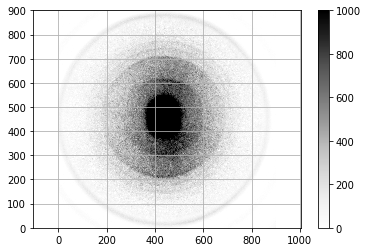

In [21]:
img = sum(img for img in diff if not np.isnan(img).any()).T

plt.figure()
plt.pcolormesh(img.T, cmap="Greys")
plt.grid(True)
plt.axis("equal")
plt.colorbar()
plt.clim(0, 1000)
plt.show()

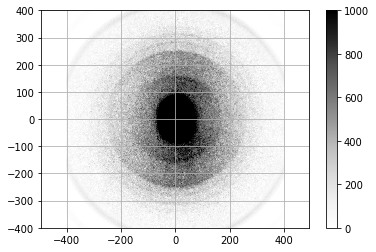

In [23]:
xn, yn = img.shape
xedges = np.arange(xn + 1)
yedges = np.arange(yn + 1)
f = interp(img, xedges, yedges)
g = transpose_linearly(f, np.eye(2), x0=np.array([432, 459]))
zedges = np.arange(-400, 400 + 1)
transformed = tohist(g, zedges, zedges)

plt.figure()
plt.pcolormesh(zedges, zedges, transformed.T, cmap="Greys")
plt.grid(True)
plt.axis("equal")
plt.colorbar()
plt.clim(0, 1000)
plt.show()

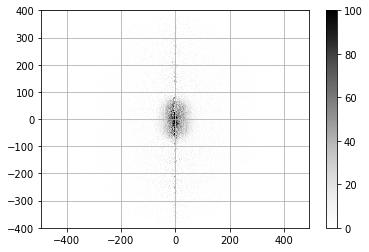

In [25]:
# Abel invert the image
z = (zedges[1:] + zedges[:-1]) / 2
xx, yy = np.meshgrid(z, z, indexing='ij')
rr = (xx ** 2 + yy ** 2) ** 0.5
clean = transformed.copy()
clean[380 < rr] = 0
dz = zedges[1:] - zedges[:-1]
inverted = abel_inverse(clean, zedges) * dz[None, :]  # shape: (r, z)

plt.figure()
plt.pcolormesh(zedges, zedges, inverted.T, cmap="Greys")
plt.grid(True)
plt.axis("equal")
plt.colorbar()
plt.clim(0, 100)
plt.show()

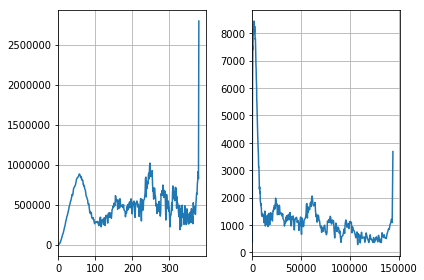

In [26]:
# Transpose to other spaces
sliced = interp(inverted, zedges, zedges)  # (rho, z) -> intensity
redges, thedges = np.linspace(0, 380, 381), np.linspace(-np.pi, np.pi, 361)
hist_indrdomega = tohist(transpose_to_drdomega(sliced), redges, thedges)  # (r, th) -> intensity
hist_indrdth = tohist(transpose_to_drdth(sliced), redges, thedges)  # (r, th) -> intensity
_, coeff, _ = finite_legendre_transform_in_theta(
    hist_indrdomega.sum(0), thedges, 6,
)  # Shapes of returns: (n, r) (n, r) (n, th)

r = (redges[1:] + redges[:-1]) / 2

plt.figure()
plt.subplot(121)
plt.plot(r, hist_indrdth.sum(1))
plt.xlim(0, None)
# plt.yscale("log")
plt.grid(True)

plt.subplot(122)
plt.plot(r**2, hist_indrdth.sum(1)/2/r)
plt.xlim(0, None)
plt.grid(True)
plt.tight_layout()
plt.show()